We have a Twitter Movie Ratings dataset, 
* movies (with IMDB id, title and year, and genre tags)
* users (connection to real Twitter ID. We don't use handle because it can change, but lookup through tweeterid.com is possible)
* ratings (user-movie edge, rated 1-10 with timestamp).


In [1]:
import pandas as pd

DIR = 'snapshots/10K/'
#DIR = 'latest/'

movies_frame = pd.read_csv(DIR + 'movies.dat', sep='::', engine='python',
                          names=['movie_id', 'title_and_year', 'bar_sep_genres']).dropna()

users_frame = pd.read_csv(DIR + 'users.dat', sep='::', engine='python',
                          names=['user_id', 'twitter_id']).dropna()

ratings_frame = pd.read_csv(DIR + 'ratings.dat', sep='::', engine='python',
                          names=['user_id', 'movie_id', 'rating', 'timestamp']).dropna()


Examining the data

In [2]:
print(movies_frame.count())
movies_frame[:5]

movie_id          3082
title_and_year    3082
bar_sep_genres    3082
dtype: int64


,movie_id,title_and_year,bar_sep_genres
0,2844,Fantômas - À l'ombre de la guillotine (1913),Crime|Drama
1,7264,The Rink (1916),Comedy|Short
2,8133,The Immigrant (1917),Short|Comedy|Drama|Romance
3,12349,The Kid (1921),Comedy|Drama|Family
4,13427,Nanook of the North (1922),Documentary


These are movies with data from IMDB, tags are separated by bars.

In [3]:
print(users_frame.count())
users_frame[:5]

user_id       3794
twitter_id    3794
dtype: int64


,user_id,twitter_id
0,1,177651718
1,2,103607473
2,3,288317450
3,4,68640782
4,5,199219885


In [4]:
print(ratings_frame.count())
ratings_frame[:5]

user_id      10000
movie_id     10000
rating       10000
timestamp    10000
dtype: int64


,user_id,movie_id,rating,timestamp
0,1,120735,9,1363245118
1,2,2592910,10,1362901837
2,3,1924396,8,1363566189
3,4,887912,8,1363557326
4,5,1182350,7,1362869000


In [5]:
# Converting UNIX timestamp to more handy format
import datetime
ratings_frame['timestamp'] = ratings_frame['timestamp'].apply(datetime.date.fromtimestamp)


The only use we can have of _users_ is if we want to look up their real-life Twitter handle. Since we are not interested in individual users, we can ignore this frame entirely.

We will now start a graph-based analysis of the dataset.

In [6]:
# Transforming ID:s in ratings DataFrame 
# to distinguish movies and users
ratings_frame['movie_id'] = 'm' + ratings_frame['movie_id'].astype(str)
ratings_frame['user_id'] = 'u' + ratings_frame['user_id'].astype(str)
ratings_frame[:5]

,user_id,movie_id,rating,timestamp
0,u1,m120735,9,2013-03-14
1,u2,m2592910,10,2013-03-10
2,u3,m1924396,8,2013-03-18
3,u4,m887912,8,2013-03-17
4,u5,m1182350,7,2013-03-09


In [7]:
import networkx as nx

G = nx.from_pandas_edgelist(
    ratings_frame,
    source='user_id',
    target='movie_id',
    edge_attr=True,
    create_using=nx.DiGraph)

Visualizing a small part of the graph:

{'m120735': 'Lock, Stock and Two Smoking Barrels (1998)', 'u1': 'User u1', 'u466': 'User u466', 'u1575': 'User u1575', 'u2028': 'User u2028'}



/opt/anaconda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


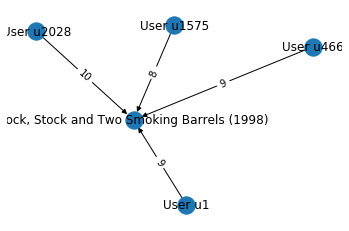

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.axis('off')

user_ids = []
movie_ids = []
for node in G.nodes:
    # Skip until first movie with many ratings
    if node[0] != 'm' or nx.degree(G, node) < 3:
        continue
    movie_ids.append(node)
    # Incoming edges, reversed neighbors
    user_ids += nx.neighbors(nx.reverse_view(G), node)
    break

subG = nx.subgraph(G, user_ids + movie_ids)
p = nx.spring_layout(subG)

node_labels = {mid: list(movies_frame[movies_frame['movie_id'] == int(mid[1:])]['title_and_year'])[0] 
               for mid in movie_ids}
node_labels.update({uid: 'User {}'.format(uid) for uid in user_ids})

print(node_labels)
nx.draw_networkx(subG, pos=p, labels=node_labels)
label_dict = subG.edges
first = list(subG.edges)[0]
edge_ratings = nx.get_edge_attributes(subG, 'rating')
nx.draw_networkx_edge_labels(subG, pos=p, edge_labels=edge_ratings)
#plt.show()
print()